##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 深度卷积生成对抗网络

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/generative/dcgan">
    <img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />
    在 tensorFlow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/dcgan.ipynb">
    <img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />
    在 Google Colab 中运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/dcgan.ipynb">
    <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" />
    在 GitHub 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/generative/dcgan.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />下载 notebook</a>
  </td>
</table>

Note: 我们的 TensorFlow 社区翻译了这些文档。因为社区翻译是尽力而为， 所以无法保证它们是最准确的，并且反映了最新的
[官方英文文档](https://www.tensorflow.org/?hl=en)。如果您有改进此翻译的建议， 请提交 pull request 到
[tensorflow/docs](https://github.com/tensorflow/docs) GitHub 仓库。要志愿地撰写或者审核译文，请加入
[docs-zh-cn@tensorflow.org Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-zh-cn)。

本教程演示了如何使用[深度卷积生成对抗网络](https://arxiv.org/pdf/1511.06434.pdf)（DCGAN）生成手写数字图片。该代码是使用 [Keras Sequential API](https://tensorflow.google.cn/guide/keras) 与 `tf.GradientTape` 训练循环编写的。

## 什么是生成对抗网络？

[生成对抗网络](https://arxiv.org/abs/1406.2661)（GANs）是当今计算机科学领域最有趣的想法之一。两个模型通过对抗过程同时训练。一个*生成器*（“艺术家”）学习创造看起来真实的图像，而*判别器*（“艺术评论家”）学习区分真假图像。

![生成器和判别器图示](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

训练过程中，*生成器*在生成逼真图像方面逐渐变强，而*判别器*在辨别这些图像的能力上逐渐变强。当*判别器*不再能够区分真实图片和伪造图片时，训练过程达到平衡。

![生成器和判别器图示二](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

本笔记在 MNIST 数据集上演示了该过程。下方动画展示了当训练了 50 个epoch （全部数据集迭代50次） 时*生成器*所生成的一系列图片。图片从随机噪声开始，随着时间的推移越来越像手写数字。

![输出样本](https://tensorflow.google.cn/images/gan/dcgan.gif)

要了解关于 GANs 的更多信息，我们建议参阅 MIT的 [深度学习入门](http://introtodeeplearning.com/) 课程。

### Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.3.1'

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### 加载和准备数据集

您将使用 MNIST 数据集来训练生成器和判别器。生成器将生成类似于 MNIST 数据集的手写数字。

In [8]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [10]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 将图片标准化到 [-1, 1] 区间内

In [11]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [12]:
# 批量化和打乱数据
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
from PIL import Image

In [20]:
img = Image.open("data/thelight.jpg")

In [21]:
a = tf.keras.preprocessing.image.img_to_array(img)

<Figure size 2880x1440 with 0 Axes>

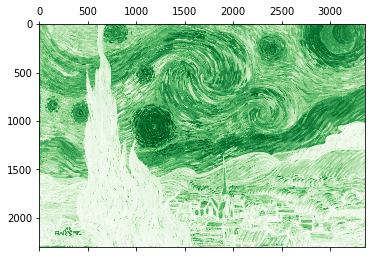

In [22]:
plt.figure(figsize=[40,20])
plt.matshow(a[:, :, 1], cmap=plt.cm.Greens)
#plt.imshow(a.astype(int))

## 创建模型

生成器和判别器均使用 [Keras Sequential API](https://tensorflow.google.cn/guide/keras#sequential_model) 定义。

### 生成器

生成器使用 `tf.keras.layers.Conv2DTranspose` （上采样）层来从种子（随机噪声）中产生图片。以一个使用该种子作为输入的 `Dense` 层开始，然后多次上采样直到达到所期望的 28x28x1 的图片尺寸。注意除了输出层使用 tanh 之外，其他每层均使用 `tf.keras.layers.LeakyReLU` 作为激活函数。

In [23]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 注意：batch size 没有限制

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

使用（尚未训练的）生成器创建一张图片。

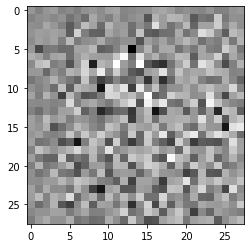

In [24]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### 判别器

判别器是一个基于 CNN 的图片分类器。

In [28]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

使用（尚未训练的）判别器来对图片的真伪进行判断。模型将被训练为为真实图片输出正值，为伪造图片输出负值。

In [29]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[1.8969098e-05]], shape=(1, 1), dtype=float32)


## 定义损失函数和优化器

为两个模型定义损失函数和优化器。

In [30]:
# 该方法返回计算交叉熵损失的辅助函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 判别器损失

该方法量化判别器从判断真伪图片的能力。它将判别器对真实图片的预测值与值全为 1 的数组进行对比，将判别器对伪造（生成的）图片的预测值与值全为 0 的数组进行对比。

In [31]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 生成器损失

生成器损失量化其欺骗判别器的能力。直观来讲，如果生成器表现良好，判别器将会把伪造图片判断为真实图片（或 1）。这里我们将把判别器在生成图片上的判断结果与一个值全为 1 的数组进行对比。

In [32]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

由于我们需要分别训练两个网络，判别器和生成器的优化器是不同的。

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 保存检查点

本笔记还演示了如何保存和恢复模型，这在长时间训练任务被中断的情况下比较有帮助。

In [34]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 定义训练循环


In [35]:
#EPOCHS = 50
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16


# 我们将重复使用该种子（因此在动画 GIF 中更容易可视化进度）
seed = tf.random.normal([num_examples_to_generate, noise_dim])

训练循环在生成器接收到一个随机种子作为输入时开始。该种子用于生产一张图片。判别器随后被用于区分真实图片（选自训练集）和伪造图片（由生成器生成）。针对这里的每一个模型都计算损失函数，并且计算梯度用于更新生成器与判别器。

In [36]:
# 注意 `tf.function` 的使用
# 该注解使函数被“编译”
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output) 

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [37]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # 继续进行时为 GIF 生成图像
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 每 15 个 epoch 保存一次模型
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 最后一个 epoch 结束后生成图片
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

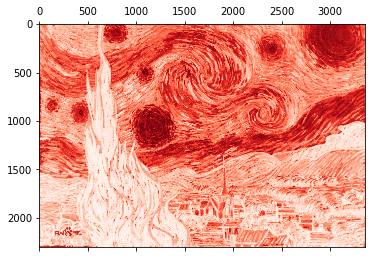

In [38]:
arr_img = tf.keras.preprocessing.image.img_to_array(img)
for i in [plt.cm.Greens, plt.cm.Blues, plt.cm.Reds]:
  display.clear_output(wait=True)
  plt.matshow(arr_img[:,:,0], cmap=i)
  time.sleep(1)
  plt.show()

**生成与保存图片**


In [39]:
def generate_and_save_images(model, epoch, test_input):
  # 注意 training` 设定为 False
  # 因此，所有层都在推理模式下运行（batchnorm）。
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

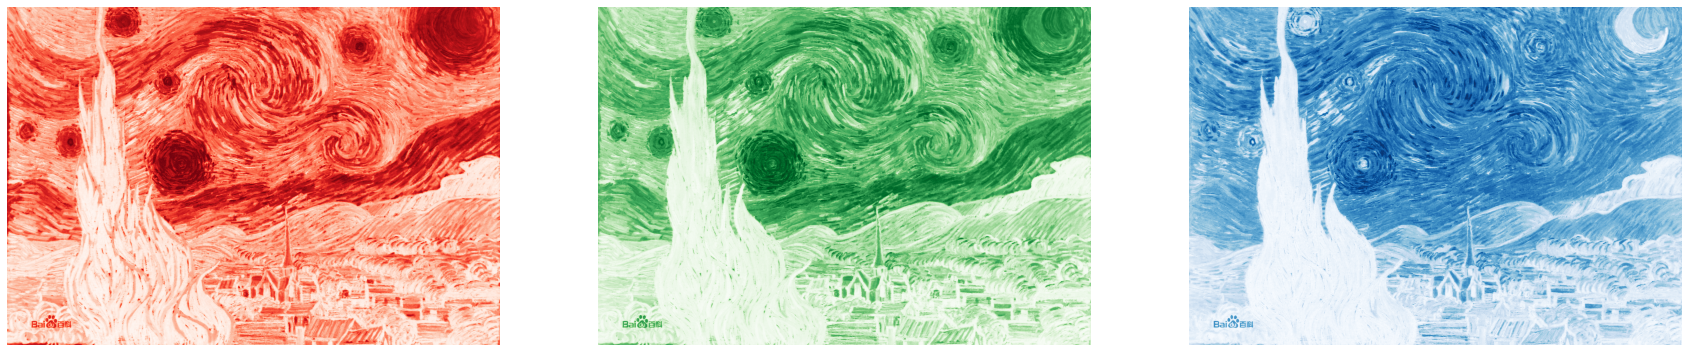

In [40]:
plt.figure(figsize=(30,10))
c = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues]
for i in range(3):
  display.clear_output(wait=True)
  plt.subplot(1, 3, i+1)
  plt.imshow(arr_img[:,:,i], cmap=c[i])
  plt.axis('off')
plt.show()

## 训练模型
调用上面定义的 `train()` 方法来同时训练生成器和判别器。注意，训练 GANs 可能是棘手的。重要的是，生成器和判别器不能够互相压制对方（例如，他们以相似的学习率训练）。

在训练之初，生成的图片看起来像是随机噪声。随着训练过程的进行，生成的数字将越来越真实。在大概 50 个 epoch 之后，这些图片看起来像是 MNIST 数字。使用 Colab 中的默认设置可能需要大约 1 分钟每 epoch。

In [42]:
%%time
train(train_dataset, EPOCHS)

KeyboardInterrupt: 

恢复最新的检查点。

In [72]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 创建 GIF


In [73]:
# 使用 epoch 数生成单张图片
def display_image(epoch_no):
  return PIL.Image.open('images/image_at_epoch_{:04d}.png'.format(epoch_no))

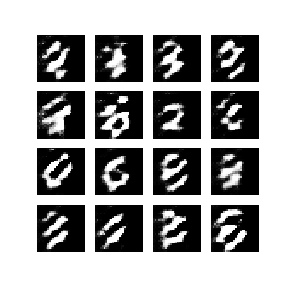

In [80]:
display_image(EPOCHS)

使用训练过程中生成的图片通过 `imageio` 生成动态 gif 

In [27]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('images/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [94]:
gif = imageio.get_writer('images/nums.gif')
for i in glob.glob('images/*png'):
    gif.append_data(imageio.imread(i))

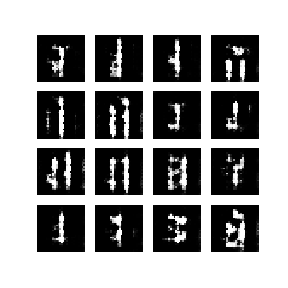

In [95]:
display.Image('images/nums.gif')

如果您正在使用 Colab，您可以通过如下代码下载动画：

In [28]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

## 下一步


本教程展示了实现和训练 GAN 模型所需的全部必要代码。接下来，您可能想尝试其他数据集，例如大规模名人面部属性（CelebA）数据集 [在 Kaggle 上获取](https://www.kaggle.com/jessicali9530/celeba-dataset)。要了解更多关于 GANs 的信息，我们推荐参阅 [NIPS 2016 教程： 生成对抗网络](https://arxiv.org/abs/1701.00160)。